In [1]:
Threads.nthreads()

1

In [2]:
using Symbolics

In [3]:
@variables t
@variables U(t)
U

U(t)

In [4]:
typeof(t)

Num

In [5]:
function f()
    @variables Y[1:10]
    return Y
end

Z = f()[1]

Y[1]

In [29]:
using Catalyst, Symbolics
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")

done


In [10]:
using Plots

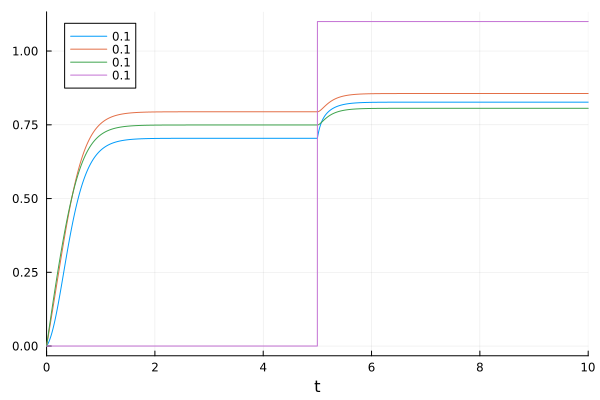

In [10]:
function run_with_fixed_perturbations(crn, state0, control, parameters, input, perturbation_list, t0, t1, reltol=1e-12, abstol=1e-12)
    condition = [t0]
    solutions = Array{Any}(undef, length(perturbation_list))
    prob = ODEProblem(crn, vcat(state0..., control...), (0., t1), parameters, check_length=false)

    Threads.@threads for i in 1:length(perturbation_list)
        function affect!(integrator)
            integrator[:U] = max(0., input + perturbation_list[i])
        end
        ps_cb = PresetTimeCallback(condition, affect!)
        sol = solve(prob, Tsit5(), reltol=reltol, abstol=abstol, callback=ps_cb)
        solutions[i] = sol
    end
    return solutions
end

perturbation_list = [0.1, 0.2, 0.3, 0.4, 0.5]

solutions = run_with_fixed_perturbations(C.ode, [0. for i in 1:3], [0.], [rand() for _ in 1:80], 1., perturbation_list, 5., 10.)

plot(solutions[1], label="0.1", idxs=1:4)

In [26]:
perturbation_list = [rand() for _ in 1:10000]

input = 1
u0 = [0. for _ in 1:243]
control0 = [input]
p0 = [rand() for _ in 1:80]
t0 = 5.
t1 = 10.
base_problem = SynthEvo.make_base_problem(C, C.ext_ode, u0, control0, p0, t0, true, 0.1)
println("done")

done


In [29]:
using Plots

In [22]:
shared_solution, solutions = SynthEvo.run_SF_CPU(C, base_problem, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

# plot(shared_solution, idxs=1:3, label=false)
# for i in 1:length(solutions)
#     plot!(solutions[i], idxs=1:3, label=false, color=colors[(i+3) % length(colors) + 1])
# end
# plot!()
# xlims!(0., 10.)

done


In [31]:
parameter_sets = [[rand() for _ in 1:80] for _ in 1:1]
@time solutions = SynthEvo.runp_SF_CPU(C, base_problem, parameter_sets, t0, t1, perturbation_list, 1e-5, 1e-5, true, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

# plot()
# for i in 1:length(solutions)
#     plot!(solutions[i][1], idxs=1:3, label=false)
#     for j in 1:length(solutions[i][2])
#         plot!(solutions[i][2][j], idxs=1:3, label=false, color=colors[(j+3) % length(colors) + 1])
#     end
# end
# plot!()
# xlims!(0., 10.)

  5.271454 seconds (937.65 k allocations: 1.125 GiB, 15.09% gc time)
done


In [131]:
reduced_base_problem = SynthEvo.make_base_problem(C, C.ode, u0[1:3], control0, p0, t0, false, 5)
@time solutions = SynthEvo.runp_SF_CPU(C, C.ode, reduced_base_problem, parameter_sets, t0, t1, perturbation_list, 1e-5, 1e-5, false, 5)
println("done")

  0.789858 seconds (600.07 k allocations: 80.957 MiB)
done


### Loss functions

In [ ]:
function test_loss_f(trajectory)
    w1 = 1.
    w2 = 2.
    loss = w1*(trajectory(5.) - trajectory(10.))**2 + w2
    mandatory_eval_points = [5., 10.]
    return (loss = loss, eval_pt = mandatory_eval_points)
end



### GPU stuff

In [ ]:
using CUDA, StaticArrays, DiffEqGPU

function run_CUDA(ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    solutions = Array{Any}(undef, length(perturbation_list))
    shared_problem = ODEProblem(ode, cu(vcat(state0..., control0...)), (0., t_shared), cu(parameters), check_length=false, saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, Tsit5(), reltol=reltol, abstol=abstol)

    problem = ODEProblem(ode, cu(shared_solution.u[end]), (t_shared, t_unique), cu(parameters), check_length=false, saveat=verbose ? true : where1, save_everystep=verbose)
    for i in 1:length(controls)
        problem = remake(problem, u0=cu(vcat(shared_solution.u[end][1:length(state0)], controls[i]...)))
        sol = solve(problem, Tsit5(), reltol=reltol, abstol=abstol)
        solutions[i] = sol
    end
    return (shared_solution, solutions)
end

perturbation_list = [2, 3]

input = 1
shared_solution, solutions = run_CUDA(C.ode, [0. for _ in 1:3], [input], [rand() for _ in 1:80], 5., 10., perturbation_events(1., perturbation_list), 1e-5, 1e-5, true, 0.25, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:length(solutions)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)

In [221]:
using DiffEqGPU, CUDA, StaticArrays, Setfield

function lorenz(u, p, t)
    σ = p[1]
    ρ = p[2]
    β = p[3]
    out = @SVector Float32[0, 0, 0]
    @set! out[1] = σ * (u[2] - u[1])
    @set! out[2] = u[1] * (ρ - u[3]) - u[2]
    @set! out[3] = u[1] * u[2] - β * u[3]
    return out
end

u0 = @SVector [1.0f0; 0.0f0; 0.0f0]
tspan = (0.0f0, 10.0f0)
p = @SVector [10.0f0, 28.0f0, 8 / 3.0f0]
prob = ODEProblem{false}(lorenz, u0, tspan, p)
prob_func = (prob, i, repeat) -> remake(prob, p = (@SVector rand(Float32, 3)) .* p .+ i)
monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)

@time sol = solve(monteprob, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()),
    trajectories = 10_000, adaptive = false, dt = 0.1f0)

  0.687617 seconds (1.34 M allocations: 96.498 MiB, 81.61% compilation time: 5% of which was recompilation)


EnsembleSolution Solution of length 10000 with uType:
ODESolution{Float32, 2, SubArray{SVector{3, Float32}, 1, Matrix{SVector{3, Float32}}, Tuple{UnitRange{Int64}, Int64}, true}, Nothing, Nothing, SubArray{Float32, 1, Matrix{Float32}, Tuple{UnitRange{Int64}, Int64}, true}, Nothing, DiffEqGPU.ImmutableODEProblem{SVector{3, Float32}, Tuple{Float32, Float32}, false, SVector{3, Float32}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(lorenz), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, GPUTsit5, SciMLBase.LinearInterpolation{SubArray{Float32, 1, Matrix{Float32}, Tuple{UnitRange{Int64}, Int64}, true}, SubArray{SVector{3, Float32}, 1, Matrix{SVector{3, Float32}}, Tuple{UnitRange{Int64}, 

In [230]:
using ModelingToolkit, Cthulhu

In [234]:
C.ode

Model control_ode with 4 equations
States (4):
  x_1(t)
  x_2(t)
  x_3(t)
  U(t)
Parameters (80):
  k[51]
  k[55]
  k[76]
  k[6]
  k[60]
  k[16]
⋮

In [ ]:
using CUDA, StaticArrays, DiffEqGPU


function run_CUDAensamble(ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    t_shared = convert(Float32, t_shared)
    t_unique = convert(Float32, t_unique)

    u0 = arr2svec(vcat(state0..., control0...))
    println(typeof(u0))
    
    shared_problem = ODEProblem{false}(ode, u0, (convert(Float32, 0.), convert(Float32, t_shared)), arr2svec(parameters), saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, GPUTsit5(), reltol=reltol, abstol=abstol)


    problem = ODEProblem{false}(ode, arr2svec(shared_solution.u[end]), (t_shared, t_unique), (parameters), check_length=false, saveat=verbose ? true : where1, save_everystep=verbose)
    problem_func = (problem, i, repeat) -> remake(problem, p = arr2svec(vcat(shared_solution.u[end][1:C.N], controls[i]..., shared_solution.u[end][C.N+length([controls[i]...])+1:end])))
    multi_problem = EnsembleProblem(problem, prob_func = problem_func, safetycopy = false)
    solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories = length(controls), adaptive = true, reltol=1e-3, abstol=1e-3)

    return (shared_solution, solutions)
end

perturbation_list = [2, 3, 4, 5]

input = 1

shared_solution, solutions = run_CUDAensamble(C.ode, [0. for _ in 1:3], [input], [rand() for _ in 1:80], 5., 10., perturbation_events(1., perturbation_list), 1e-5, 1e-5, true, 0.25, 0.25)

println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:size(solutions, 1)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)

In [33]:
using Catalyst, Symbolics, Plots, DifferentialEquations
include("../src/SynthEvo.jl")
C = SynthEvo.make_FullyConnectedNonExplosive_CRN(3)
println("done")


function perturbation_events(input, perturbation_list)
    return [[input + rand()*p - p/2] for p in perturbation_list]
end

function arr2svec(arr)
    return SVector{length(arr), Float32}(convert(Array{Float32}, arr))
end

using CUDA, StaticArrays, DiffEqGPU

done


In [81]:
function make_alternative_ode(C)
    """
    Extend the ODE system with the sensitivity equations.

    Args:
    - `C`: the CRN model

    Returns:
    - the sensitivity ODE system
    """

    S = SynthEvo.sensitivity(C)

    D = Differential(C.time)
    # convert to ODESystem
    eqs = []
    for i in 1:length(equations(C.ode))
        push!(eqs, equations(C.ode)[i])
    end
    # push!(eqs, D(C.control) ~ Num(0))
    for i in 1:size(S,1)
        for j in 1:size(S,2)
            # if isequal(S[i,j], Num(0))
            #     continue
            # end
            if i==1 and j==1
                push!(eqs, D(C.sensitivity_variables[i,j]) ~ S[i,j])
            end
        end
    end
    return @named senesitivity_ode = ODESystem(eqs, C.time)
end

make_alternative_ode (generic function with 1 method)

In [82]:

function run_CUDAensamble(C, ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    t_shared = convert(Float32, t_shared)
    t_unique = convert(Float32, t_unique)

    u0 = arr2svec(vcat(state0..., control0...))
    p0 = arr2svec(parameters)
    
    shared_problem = ODEProblem(ode, u0, (0., t_shared), p0, saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, GPUTsit5(), reltol=reltol, abstol=abstol)

    problem = ODEProblem(ode, u0, (t_shared, t_unique), p0, saveat=verbose ? arr2svec(((t_unique-t_shared)/100)*(0:100) .+ t_shared) : where1, save_everystep=verbose)
    
    function change_control(u0, new_control)
        U = arr2svec(vcat(u0[1:C.N], new_control..., u0[C.N+length([new_control...])+1:end]))
        return U
    end

    problem_func = (problem, i, repeat) -> remake(problem, u0=change_control(shared_solution.u[end], controls[i]), p=rand(80))

    multi_problem = EnsembleProblem(problem; prob_func = problem_func, safetycopy = false)

    #solutions = solve(multi_problem, Tsit5(), EnsembleGPUArray(CUDA.CUDABackend()), trajectories=1000, adaptive = true, reltol=1e-7, abstol=1e-7) # this works
    solutions = solve(multi_problem, GPUTsit5(),  EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=length(controls), adaptive = true, reltol=1e-7, abstol=1e-7)

    return (shared_solution, solutions)
end

n_inpt = 1000
perturbation_list = 1 .+ rand(n_inpt)

input = 1

@time shared_solution, solutions = run_CUDAensamble(C, make_alternative_ode(C), [0. for _ in 1:243], [input], [rand() for _ in 1:80], 5., 10., perturbation_list, 1e-5, 1e-5, true, 0.25, 0.25)
nothing
# println("done")
# colors = get_color_palette(:auto, plot_color(:white))

# plot(shared_solution, idxs=1:3, label=false)
# for i in 1:min(10, size(solutions)[end])
#     plot!(solutions[i], idxs=1:3, label=false, color=colors[(i+3)%16 + 1])
# end
# plot!()
# xlims!(0., 10.)
# ylims!(0., 2.)

GPUCompiler.InvalidIRError: InvalidIRError: compiling MethodInstance for DiffEqGPU.gpu_ode_asolve_kernel(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{1, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}}, ::CuDeviceVector{DiffEqGPU.ImmutableODEProblem{SVector{244, Float32}, Tuple{Float32, Float32}, true, SVector{80, Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#k#503"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xfab7ad95, 0x41a84629, 0xfd35a863, 0xfb11e37c, 0xe2c9c2e6), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xc2a53a01, 0x7beda0d4, 0x70b51d3c, 0xbafb3275, 0xa4125b1e), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.var"#1269#generated_observed#513"{Bool, ODESystem, Dict{Any, Any}, Vector{SymbolicUtils.BasicSymbolic{Real}}}, Nothing, ODESystem, Nothing, Nothing}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol}, @NamedTuple{saveat::SVector{101, Float32}, save_everystep::Bool}}, SciMLBase.StandardODEProblem}, 1}, ::GPUTsit5, ::CuDeviceMatrix{SVector{244, Float32}, 1}, ::CuDeviceMatrix{Float32, 1}, ::Float32, ::CallbackSet{Tuple{}, Tuple{}}, ::Nothing, ::Float32, ::Float32, ::SVector{101, Float32}, ::Val{false}) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to julia.new_gc_frame)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.push_gc_frame)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.get_gc_frame_slot)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to jl_f__apply_iterate)
Stacktrace:
 [1] create_array
   @ ~/.julia/packages/SymbolicUtils/c0xQb/src/code.jl:553
 [2] macro expansion
   @ ~/.julia/packages/SymbolicUtils/c0xQb/src/code.jl:468
 [3] macro expansion
   @ ~/.julia/packages/RuntimeGeneratedFunctions/Yo8zx/src/RuntimeGeneratedFunctions.jl:163
 [4] macro expansion
   @ ./none:0
 [5] generated_callfunc
   @ ./none:0
 [6] RuntimeGeneratedFunction
   @ ~/.julia/packages/RuntimeGeneratedFunctions/Yo8zx/src/RuntimeGeneratedFunctions.jl:150
 [7] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.pop_gc_frame)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.new_gc_frame)
Stacktrace:
 [1] k
   @ ~/.julia/packages/ModelingToolkit/Gpzyo/src/systems/diffeqs/abstractodesystem.jl:370
 [2] ODEFunction
   @ ~/.julia/packages/SciMLBase/NjslX/src/scimlfunctions.jl:2184
 [3] step!
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/perform_step/gpu_tsit5_perform_step.jl:102
 [4] macro expansion
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/kernels.jl:97
 [5] gpu_ode_asolve_kernel
   @ ~/.julia/packages/KernelAbstractions/zPAn3/src/macros.jl:95
 [6] gpu_ode_asolve_kernel
   @ ./none:0
Reason: unsupported call to an unknown function (call to julia.push_gc_frame)
Stacktrace:
 [1] k
   @ ~/.julia/packages/ModelingToolkit/Gpzyo/src/systems/diffeqs/abstractodesystem.jl:370
 [2] ODEFunction
   @ ~/.julia/packages/SciMLBase/NjslX/src/scimlfunctions.jl:2184
 [3] step!
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/perform_step/gpu_tsit5_perform_step.jl:102
 [4] macro expansion
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/kernels.jl:97
 [5] gpu_ode_asolve_kernel
   @ ~/.julia/packages/KernelAbstractions/zPAn3/src/macros.jl:95
 [6] gpu_ode_asolve_kernel
   @ ./none:0
Reason: unsupported call to an unknown function (call to julia.get_gc_frame_slot)
Stacktrace:
 [1] k
   @ ~/.julia/packages/ModelingToolkit/Gpzyo/src/systems/diffeqs/abstractodesystem.jl:370
 [2] ODEFunction
   @ ~/.julia/packages/SciMLBase/NjslX/src/scimlfunctions.jl:2184
 [3] step!
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/perform_step/gpu_tsit5_perform_step.jl:102
 [4] macro expansion
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/kernels.jl:97
 [5] gpu_ode_asolve_kernel
   @ ~/.julia/packages/KernelAbstractions/zPAn3/src/macros.jl:95
 [6] gpu_ode_asolve_kernel
   @ ./none:0
Reason: unsupported call to an unknown function (call to jl_f__apply_iterate)
Stacktrace:
  [1] create_array
    @ ~/.julia/packages/SymbolicUtils/c0xQb/src/code.jl:553
  [2] macro expansion
    @ ~/.julia/packages/SymbolicUtils/c0xQb/src/code.jl:468
  [3] macro expansion
    @ ~/.julia/packages/RuntimeGeneratedFunctions/Yo8zx/src/RuntimeGeneratedFunctions.jl:163
  [4] macro expansion
    @ ./none:0
  [5] generated_callfunc
    @ ./none:0
  [6] RuntimeGeneratedFunction
    @ ~/.julia/packages/RuntimeGeneratedFunctions/Yo8zx/src/RuntimeGeneratedFunctions.jl:150
  [7] k
    @ ~/.julia/packages/ModelingToolkit/Gpzyo/src/systems/diffeqs/abstractodesystem.jl:370
  [8] ODEFunction
    @ ~/.julia/packages/SciMLBase/NjslX/src/scimlfunctions.jl:2184
  [9] step!
    @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/perform_step/gpu_tsit5_perform_step.jl:102
 [10] macro expansion
    @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/kernels.jl:97
 [11] gpu_ode_asolve_kernel
    @ ~/.julia/packages/KernelAbstractions/zPAn3/src/macros.jl:95
 [12] gpu_ode_asolve_kernel
    @ ./none:0
Reason: unsupported call to an unknown function (call to julia.pop_gc_frame)
Stacktrace:
 [1] k
   @ ~/.julia/packages/ModelingToolkit/Gpzyo/src/systems/diffeqs/abstractodesystem.jl:370
 [2] ODEFunction
   @ ~/.julia/packages/SciMLBase/NjslX/src/scimlfunctions.jl:2184
 [3] step!
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/perform_step/gpu_tsit5_perform_step.jl:102
 [4] macro expansion
   @ ~/.julia/packages/DiffEqGPU/I999k/src/ensemblegpukernel/kernels.jl:97
 [5] gpu_ode_asolve_kernel
   @ ~/.julia/packages/KernelAbstractions/zPAn3/src/macros.jl:95
 [6] gpu_ode_asolve_kernel
   @ ./none:0
Hint: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl

done


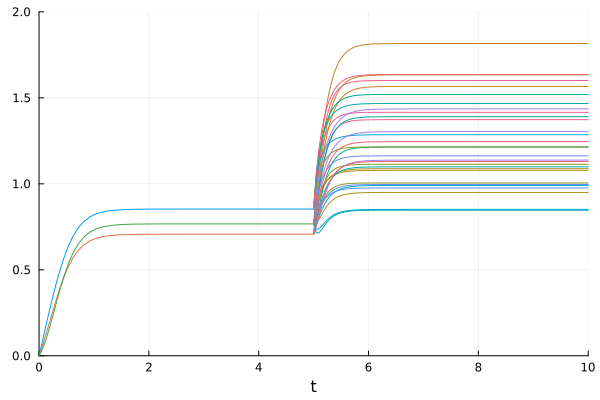

In [6]:
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:min(10, size(solutions)[end])
    plot!(solutions[i], idxs=1:3, label=false, color=colors[(i+3)%16 + 1])
end
plot!()
xlims!(0., 10.)
ylims!(0., 2.)

In [ ]:
using Catalyst, Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU
rs = @reaction_network begin
  c1, S + E --> SE
  c2, SE --> S + E
  c3, SE --> P + E
end

p = [1.0, 1.0, 1.0]
u0 = [1.0, 1.0, 1.0, 1.0]
tspan = (0.0, 10.0)
ode = convert(ODESystem, rs)
prob = ODEProblem{false}(ode, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:3)

problem_func = (problem, i, repeat) -> remake(problem, u0=rand(4))

multi_problem = EnsembleProblem(prob, prob_func = problem_func, safetycopy = false)

solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUArray(CUDA.CUDABackend()), trajectories=2, adaptive = true, reltol=1e-6, abstol=1e-6)

for s in solutions
    plot!(s, idxs=1:3, linestyle=:dash, legend=false)
end
plot!()

In [76]:
solutions

EnsembleSolution Solution of length 1 with uType:
ODESolution{Float32, 2, Vector{SVector{4, Float32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{SVector{4, Float32}}}, ODEProblem{SVector{4, Float32}, Tuple{Float64, Float64}, false, Vector{Float32}, ODEFunction{false, SciMLBase.FullSpecialize, ModelingToolkit.var"#k#503"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x6d47f296, 0x30c58367, 0x3df8d66b, 0x9d687222, 0x5051d952), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x9ecbc722, 0x3acb575f, 0x09828ff0, 0xc2a116ae, 0xa2f2f9c3), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.var"#679#generated_observed#513"{Bool, ODESystem, Dict{Any, Any}, Vector{Symb

1
2


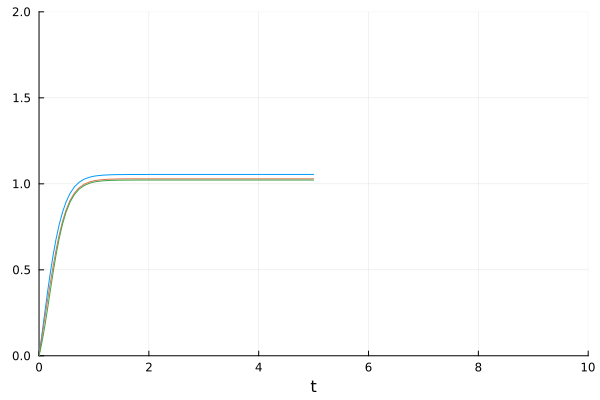

In [81]:
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:size(solutions)[end]
    println(i)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)
ylims!(0., 2.)

In [66]:
size(solutions)

(4, 1, 2)

In [114]:
v = [0. for _ in 1:3]

function arr2svec(arr)
    return SVector{length(arr), Float32}(convert(Array{Float32}, arr))
end

arr2svec(v)

3-element SVector{3, Float32} with indices SOneTo(3):
 0.0
 0.0
 0.0

In [ ]:
using CUDA, StaticArrays, DiffEqGPU

function run_CUDAensamble(ode, state0, control0, parameters, t_shared, t_unique, controls, reltol=1e-12, abstol=1e-12, verbose=true, where0=nothing, where1=nothing)
    condition = [t_shared]
    solutions = Array{Any}(undef, length(perturbation_list))
    shared_problem = ODEProblem(ode, cu(vcat(state0..., control0...)), (0., t_shared), cu(parameters), check_length=false, saveat=verbose ? true : where0, save_everystep=verbose)
    shared_solution = solve(shared_problem, Tsit5(), reltol=reltol, abstol=abstol)


    problem = ODEProblem(ode, cu(shared_solution.u[end]), (t_shared, t_unique), cu(parameters), check_length=false, saveat=verbose ? true : where1, save_everystep=verbose)
    problem_func = (prob, i, repeat) -> remake(prob, p = vcat(shared_solution.u[end][1:length(state0)], controls[i]...))
    monteprob = EnsembleProblem(prob, prob_func = prob_func, safetycopy = false)
    solutions = solve(monteprob, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories = length(controls), adaptive = true, reltol=1e-3, abstol=1e-3)

    return (shared_solution, solutions)
end

perturbation_list = [2, 3, 4, 5]

input = 1
shared_solution, solutions = run_CUDAensamble(C.ode, [0. for _ in 1:3], [input], [rand() for _ in 1:80], 5., 10., perturbation_events(1., perturbation_list), 1e-5, 1e-5, true, 0.25, 0.25)
println("done")
colors = get_color_palette(:auto, plot_color(:white))

plot(shared_solution, idxs=1:3, label=false)
for i in 1:size(solutions, 1)
    plot!(solutions[i], idxs=1:3, label=false, color=colors[i+3])
end
plot!()
xlims!(0., 10.)

: 

: 

In [64]:
size(solutions, 1)

3